In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from torch.utils.data import  DataLoader
from sklearn.metrics import accuracy_score

In [21]:
from utils.common_utils import fraud_classes_mapping

In [22]:
import torch
from torch import nn
from tqdm import tqdm
import os
from IPython import display


In [23]:
columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","target",'ne_ponytno']

In [24]:
train = pd.read_csv('../data/KDD/KDDTrain+.txt', names=columns)
test = pd.read_csv('../data/KDD/KDDTest+.txt', names=columns)

In [25]:
df = pd.concat([train,test]).drop('target',axis=1)

In [26]:
# Преобразование столбцов с 24 классами в новые классы
y_train = (fraud_classes_mapping(train.target) != 'norm').astype(int)
y_test = (fraud_classes_mapping(test.target) != 'norm').astype(int)

X_train = train.drop('target',axis=1)
X_test = test.drop('target',axis=1)

In [27]:
names_one_hot_encoding=[]
for col in df:
    # print(col, type(df[col].values[0]), len(df[col].unique()))
    if len(df[col].unique()) <= 72:
        names_one_hot_encoding.append(col)
print(names_one_hot_encoding)

['protocol_type', 'service', 'flag', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'root_shell', 'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'ne_ponytno']


# Preproc

In [28]:
enc = OneHotEncoder()
enc.fit(df[names_one_hot_encoding])
ss = StandardScaler()
ss.fit(df.drop(names_one_hot_encoding,axis=1))
def preproc(data):
    return np.concatenate([ss.transform(data.drop(names_one_hot_encoding,axis=1)),
                           enc.transform(data[names_one_hot_encoding]).toarray() ],axis=1)    


In [29]:
X_train = preproc(X_train)
X_test = preproc(X_test)


# Net structure

In [61]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        # your code here
        self.seq = nn.Sequential(
            nn.Linear(236, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Sigmoid()
        )  
    def forward(self, x):
        out = self.seq(x)
        return out

# Fitting

In [62]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
model = NN().to(device)
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [65]:
TrainLoader = DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train,requires_grad=True).float().to(device),torch.tensor(y_train).to(device)),
                         batch_size=128,shuffle=True)
# TestLoader = DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test,requires_grad=True).float().to(device),torch.tensor(y_test).to(device)),batch_size=1024)

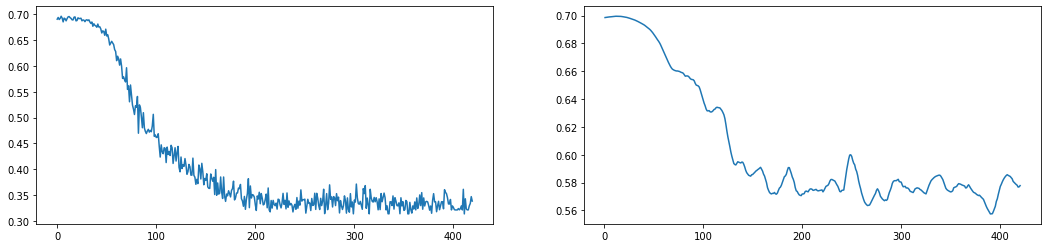

420it [05:51,  1.19it/s]


KeyboardInterrupt: 

In [66]:
n_epochs = 5
losses=[]
losses_val=[float('+inf')]


for epoch in range(n_epochs):

    for n_iter, data in tqdm(enumerate(TrainLoader)):
        inp = data[0]
        opt.zero_grad()
        pred = model(inp)
        loss = criterion(pred,data[1])
        losses.append(loss.item())
        loss.backward()
        opt.step()
        
        opt.zero_grad()
        pred = model(torch.tensor(X_test,requires_grad=True).float().to(device))
        loss = criterion(pred,torch.tensor(y_test).to(device))
        if loss.item() < min(losses_val):
            best_model = model.state_dict()       
        losses_val.append(loss.item())
        
        display.clear_output(wait=True)
        f = plt.figure(figsize=(18,4))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(losses)
        ax2.plot(losses_val)
        plt.show()

In [67]:
model.load_state_dict(best_model)
accuracy_score(model(torch.tensor(X_test).float().to(device)).detach().max(axis=1).indices.cpu().numpy(),y_test)

0.7322569198012775